In [1]:
import time
import json
import pika
import uuid
import sys
import pybars
import requests
import psycopg2
import re
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def internalProcess(url,method):  
    headers = {
        'content-type': "application/json",
        'cache-control': "no-cache",
        'postman-token': "64225f1a-4ded-800c-14f2-74ff3a3d45b9"
        }
    response = requests.request(method, url, headers=headers)   
    return response.json() 

In [3]:
#-------------------Conexión con la base de datos de Chatblocks -------------------
try:
    DNS="host='localhost' dbname='chatblocks' user='postgres' password='carlos98'"
    con=psycopg2.connect(DNS)
    cur=con.cursor()
    print("conexion exitosa")
except (Exception, psycopg2.Error) as error:
    print("Error en conexion", error) 

conexion exitosa


In [4]:
def consulta(query):
    try:
        #print("Consulta: " + query)
        DNS="host='localhost' dbname='chatblocks' user='postgres' password='carlos98'"
        con=psycopg2.connect(DNS)
        cur=con.cursor()
        cur.execute(query)
        dato=cur.fetchone()
        return dato
    except (Exception, psycopg2.Error) as error:
        print("Error en consulta", error) 
        return None

In [5]:
def consulta2(query):
    global cur
    print("Consulta 2: " + query)
    cur.execute(query)
    dato=cur.fetchall()
    return dato

In [6]:
def insertar(query):
    global cur
    global con
    cur.execute(query)
    con.commit()

In [7]:
def cerrarConexionDB():
    global cur
    global con
    cur.close()
    con.close()

In [8]:
#-----PASO 9. Variante 1: Creación de la respuesta que pertenece a un bloque simple: Informativo-----
def mensInf(state,mensaje):
    n=  {"Respuesta": {"content":" ","next_id":" ", "blockType":" ", "contentType":" ",
                         "typingTime":" ","payload":"" }}
    data_string = json.dumps(n)
    decoded = json.loads(data_string)    
    #-------PASO 9. Variante 1: Consultas a la base de datos para la creación de la respuesta--------        
    decoded["Respuesta"]["content"] = str(consulta("select contenido from bloqueinformativo where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["next_id"] = str(consulta("select next_id from bloqueinformativo where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["blockType"]= str(consulta("select blockType from bloqueinformativo where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["contentType"]= str(consulta("select contentType from bloqueinformativo where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["typingTime"]= str(consulta("select typingTime from bloqueinformativo where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    entidades=json.dumps(mensaje["payload"]["entities"])
    
    if consulta("select *from ticket")==None:
        try:
            fecha = str(time.strftime("%d/%m/%y")) 
            insertar("insert into ticket (id_robot, id_usuario, estado_actual, block_type ,entities,fecha_mod) values ('"+str(mensaje["payload"]["robot"])+"','"+mensaje["payload"]["recipient_id"]+"','"+state+"','"+"informativo','{}',"+"'"+fecha+"'"+')') 
        except:
            print("no se ha podido guardar información ")
    else:
        try:
            insertar("update ticket set entities='"+entidades+"', estado_actual='"+state+"', block_type='informativo' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
        except:
            print("no se ha actualizado informacion")
    payload={"content":"","state":state,"recipient_id":mensaje["payload"]["recipient_id"],"entities":mensaje["payload"]["entities"],"access_token":mensaje["payload"]["access_token"]}
    pay=json.dumps(payload)
    decoded["Respuesta"]["payload"]= json.loads(pay)
    
    #decoded["Respuesta"]["payload"].append(json.loads(pay))
    #----------------------PASO 10. Inicio: Retorno de la respuesta generada----------------------
    return decoded

In [9]:
def mensCase(state,mensaje):
    n=  {"Respuesta": {"content":" ","next_id":" ", "blockType":" ", "contentType":" ",
                         "typingTime":" ","payload":"" }}
    data_string = json.dumps(n)
    decoded = json.loads(data_string)
    
    bloqueCase = consulta("select * from bloquecase where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")
    url = bloqueCase[6]
    variable  = url.split('/')[4]
    print("variable: ",variable)
    operacion =  url.split('/')[3]    
    url = url.split('/')    
    url.pop(4)
    url = "/".join(url)   
    method = bloqueCase[7]
    print("url:",url,"\n metodo:",method,"\noperacion",operacion)    
    numeroMensaje = 0 
    
    value = (consulta("select var from bloquecase join variables on variables.id_var =  cast ( bloquecase.id_var as INTEGER) where bloquecase.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloquecase.namestate='"+state+"'")[0])    

    print("valor =",value)
    if operacion == "increase":    
        if value != None:
            url = url+str(value)
            print("\n url fin 1111",url,"\n")
        else:
            url = url+str("/") + str(numeroMensaje)     
            print("\n url fin 222",url,"\n")
        
    
    try:
        numeroVariable = internalProcess(url,method) 
        nombre_variable = (consulta("select name_var from bloquecase join variables on variables.id_var =  cast ( bloquecase.id_var as INTEGER) where bloquecase.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloquecase.namestate='"+state+"'")[0])    
        id_variable = (consulta("select id_var from variables where name_var= "+"'"+nombre_variable+"'"+"and id_robot = "+"'"+str(mensaje["payload"]["robot"])+"'")[0])
        insertar("update variables set var='"+str(numeroVariable["value"])+"' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_var='"+str(id_variable)+"'")   
        print("actualiza var",nombre_variable,"con: ",numeroVariable["value"])
    except:
        print("error al actualizar valor de la variable")          
    
    try:
        messages = bloqueCase[1].split(",")       
    except:
        messages=bloqueCase[1]    
        
    print("messages:",messages,"valor:", "tamaño: ",len(messages))    
    
    if type(messages) == list and len(messages)>1:
        
        try:
            message = messages[numeroVariable["value"]-1]   
            contentType =  bloqueCase[2].split(",")[numeroVariable["value"]-1]
        except:
            message = bloqueCase[9]
            contentType =  bloqueCase[10]
            
    elif type(messages) == list and len(messages)==1:
        try:
            message = messages[0] 
            contentType = bloqueCase[2]
        except:
            message = bloqueCase[9]
            contentType =  bloqueCase[10]
        
    else:
        try:
            message = messages 
            contentType = bloqueCase[2]
        except:
            message = bloqueCase[9]
            contentType =  bloqueCase[10]            
                
    print("mensaje final: ",message)  

    decoded["Respuesta"]["content"]     = str(message)
    decoded["Respuesta"]["next_id"]     = str("next")
    decoded["Respuesta"]["blockType"]   = str("informativo")
    decoded["Respuesta"]["contentType"] = str(contentType)
    decoded["Respuesta"]["typingTime"]  = str(bloqueCase[3])
    
    entidades=json.dumps(mensaje["payload"]["entities"])
    
    if consulta("select *from ticket")==None:
        try:
            fecha = str(time.strftime("%d/%m/%y")) 
            insertar("insert into ticket (id_robot, id_usuario, estado_actual, block_type ,entities,fecha_mod) values ('"+str(mensaje["payload"]["robot"])+"','"+mensaje["payload"]["recipient_id"]+"','"+state+"','"+"case','{}',"+"'"+fecha+"'"+')') 
        except:
            print("no se ha podido guardar información ")
    else:
        #insertar("update ticket set entities='"+"'"+entidades+"'"+"', estado_actual='"+state+"', block_type='case' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
        try:
            insertar("update ticket set entities='"+entidades+"', estado_actual='"+state+"', block_type='case' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
        except:
            print("no se ha actualizado informacion case")
    payload={"content":"","state":state,"recipient_id":mensaje["payload"]["recipient_id"],"entities":mensaje["payload"]["entities"],"access_token":mensaje["payload"]["access_token"]}
    pay=json.dumps(payload)
    decoded["Respuesta"]["payload"]= json.loads(pay)

    return decoded
    

In [10]:
def mensInfDatosU(mensaje,content):
    n=  {"Respuesta": {"content":" ","next_id":" ", "blockType":" ", "contentType":" ",
                         "typingTime":" ","payload":" "}}
    data_string = json.dumps(n)
    decoded = json.loads(data_string)
    
    decoded["Respuesta"]["content"] = str(content)
    decoded["Respuesta"]["blockType"]= 'informativo'
    decoded["Respuesta"]["contentType"]= 'text'
    decoded["Respuesta"]["typingTime"]= 1
    
    payload={"content":"","recipient_id":mensaje["payload"]["recipient_id"],"access_token":mensaje["payload"]["access_token"]}
    pay=json.dumps(payload)
    decoded["Respuesta"]["payload"]=json.loads(pay)
    #decoded["Respuesta"]["payload"]decoded["Respuesta"]["payload"].append(json.loads(pay))
    return decoded

In [11]:
#-----PASO 9. Variante 1: Creación de la respuesta que pertenece a un bloque simple: QuickReply-----
def mensQr(state,mensaje):
    n=  {"Respuesta": {"content":" ","next_id":" ", "blockType":" ", "contentType":" ",
                         "typingTime":" ","payload":" "}}
    data_string = json.dumps(n)
    decoded = json.loads(data_string)
    
    #-------PASO 9. Variante 1: Consultas a la base de datos para la creación de la respuesta--------
    opc=(consulta2("select opciones from bloquequickreply where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    opciones=opc[0].split(",")
    content = str(consulta("select contenido from bloquequickreply where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    
    pos = content.find("@")
    if pos != -1:
        try:
            variable = content[pos:].split(" ")[0]
        except:
            variable = content[pos:]
        valueVariable =  str(consulta("select var from variables where id_robot='"+str(mensaje["payload"]["robot"])+"' and name_var='"+variable[1:]+"'")[0])
        content = content.replace(variable,valueVariable)
        #print( "Estimado Sr. @email:".replace("@email", "oliverbp88@gmail.com") )
        print("*****************************************",content)


    decoded["Respuesta"]["content"] = content
    decoded["Respuesta"]["options"] = opciones
    decoded["Respuesta"]["next_id"] = str(consulta("select next_id from bloquequickreply where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["blockType"]= str(consulta("select blockType from bloquequickreply where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])    
    decoded["Respuesta"]["typingTime"]= str(consulta("select typingTime from bloquequickreply where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["default_id"] = str(consulta("select default_id from bloquequickreply where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    #decoded["Respuesta"][0]["save_var"] = str(consulta("select save_var from bloquequickreply where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["save_var"] = str(consulta("select var from bloquequickreply join variables on variables.id_var =  cast ( bloquequickreply.id_var as INTEGER) where bloquequickreply.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloquequickreply.namestate='"+state+"'")[0])
    
    entidades=json.dumps(mensaje["payload"]["entities"])
    print("entidades a guardar : ",entidades)
    
    if consulta("select *from ticket")==None:
        fecha = str(time.strftime("%d/%m/%y")) 
        insertar("insert into ticket (id_robot, id_usuario, estado_actual, block_type ,entities,fecha_mod) values ('"+str(mensaje["payload"]["robot"])+"','"+mensaje["payload"]["recipient_id"]+"','"+state+"','"+"quickReply',"+"'"+entidades+"'"+",'"+fecha+"'"+')') 
    else:
        insertar("update ticket set entities='"+entidades+"', estado_actual='"+state+"', block_type='quickReply' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
    
    
    
    
    
    payload={"content":"","state":state,"recipient_id":mensaje["payload"]["recipient_id"],"entities":mensaje["payload"]["entities"],"access_token":mensaje["payload"]["access_token"]}
    pay=json.dumps(payload)
    decoded["Respuesta"]["payload"]=json.loads(pay)
    #decoded["Respuesta"]["payload"].append(json.loads(pay))
    #----------------------PASO 10. Inicio: Retorno de la respuesta generada----------------------
    return decoded

In [12]:
#-----PASO 9. Variante 1: Creación de la respuesta que pertenece a un bloque simple: Input-----
def mensInp(state,mensaje):
    n=  {"Respuesta": {"content":" ","next_id":" ", "blockType":" ", "contentType":" ",
                         "typingTime":" ","payload":" "}}
    data_string = json.dumps(n)
    decoded = json.loads(data_string)
    
    #-------PASO 9. Variante 1: Consultas a la base de datos para la creación de la respuesta--------
    decoded["Respuesta"]["content"] = str(consulta("select contenido from bloqueinput where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])    
    decoded["Respuesta"]["next_id"] = str(consulta("select next_id from bloqueinput where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["blockType"]= str(consulta("select blockType from bloqueinput where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])    
    decoded["Respuesta"]["contentType"]= str(consulta("select contentType from bloqueinput where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])    
    decoded["Respuesta"]["typingTime"]= str(consulta("select typingTime from bloqueinput where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["validacion"]= str(consulta("select validacion from bloqueinput where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["default_id"] = str(consulta("select default_id from bloqueinput where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    #decoded["Respuesta"][0]["save_var"] = str(consulta("select save_var from bloqueinput where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    entidades=json.dumps(mensaje["payload"]["entities"])
    if consulta("select *from ticket")==None:
        fecha = str(time.strftime("%d/%m/%y")) 
        insertar("insert into ticket (id_robot, id_usuario, estado_actual, block_type ,entities,fecha_mod) values ('"+str(mensaje["payload"]["robot"])+"','"+mensaje["payload"]["recipient_id"]+"','"+state+"','"+"input','{}',"+"'"+fecha+"'"+')') 
    else:
        insertar("update ticket set entities='"+entidades+"', estado_actual='"+state+"', block_type='input' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
    
    payload={"content":"","state":state,"recipient_id":mensaje["payload"]["recipient_id"],"entities":mensaje["payload"]["entities"],"access_token":mensaje["payload"]["access_token"]}
    pay=json.dumps(payload)
    decoded["Respuesta"]["payload"] = json.loads(pay)
    #decoded["Respuesta"]["payload"].append(json.loads(pay))
    #----------------------PASO 10. Inicio: Retorno de la respuesta generada----------------------
    return decoded

In [13]:
#-----PASO 9. Variante 1: Creación de la respuesta que pertenece a un bloque simple: Slide-----
def mensSlide(state,mensaje):
    n=  {"Respuesta": {"content":" ","next_id":" ", "blockType":" ", "contentType":" ",
                         "typingTime":" ","payload":" "}}
    data_string = json.dumps(n)
    decoded = json.loads(data_string)
    
    #-------PASO 9. Variante 1: Consultas a la base de datos para la creación de la respuesta--------
    id_block,next_id,blocktype,typingtime,default_id = consulta("select id_block,next_id,blocktype,typingtime,default_id from bloqueslide where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")
    save_var = str(consulta("select var from bloqueslide join variables on variables.id_var =  cast ( bloqueslide.id_var as INTEGER) where bloqueslide.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloqueslide.namestate='"+state+"'")[0]) 
    data_elements=consulta2("select * from elementos where id_block='"+str(id_block)+"' and blocktype='slide'")    
    
    elements=[]    
    for element in data_elements:
        for elm in element:
            print('Elemento-> ',elm)        
        buttons =[]    
        data_buttons=consulta2("select * from botones where id_elemento='"+str(element[5])+"'")
        print("Data Buttons")
        print(data_buttons)
        for btn in data_buttons:
            if btn[2]=='postback':
                button={'titleButton':btn[1],'typeButton':'postback','payloadButton':btn[3]}
            if btn[2]=='web_url':
                button={'titleButton':btn[1],'typeButton':'web_url','urlButton':btn[3]}
            buttons.append(button)                
        data={'title':element[1], 'image_url':element[2], 'subtitle':element[3], 'buttons':buttons}
        elements.append(data)    
    print(next_id)
    opciones=next_id.split(",")        
    decoded["Respuesta"]["content"] = elements
    decoded["Respuesta"]["next_id"] = opciones
    decoded["Respuesta"]["blockType"]= str(blocktype)    
    decoded["Respuesta"]["typingTime"]= int(typingtime)
    decoded["Respuesta"]["default_id"] = str(default_id)
    decoded["Respuesta"]["save_var"] = str(save_var)   
    
    entidades=json.dumps(mensaje["payload"]["entities"])    
    if consulta("select *from ticket")==None:
        fecha = str(time.strftime("%d/%m/%y")) 
        insertar("insert into ticket (id_robot, id_usuario, estado_actual, block_type ,entities,fecha_mod) values ('"+str(mensaje["payload"]["robot"])+"','"+mensaje["payload"]["recipient_id"]+"','"+state+"','"+"slide','{}',"+"'"+fecha+"'"+')') 
    else:        
        insertar("update ticket set entities='"+entidades+"', estado_actual='"+state+"', block_type='slide' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
    payload={"content":"","state":state,"recipient_id":mensaje["payload"]["recipient_id"],"entities":mensaje["payload"]["entities"],"access_token":mensaje["payload"]["access_token"]}
    pay=json.dumps(payload)
    decoded["Respuesta"]["payload"]=json.loads(pay)
    #decoded["Respuesta"]["payload"].append(json.loads(pay))
    #----------------------PASO 10. Inicio: Retorno de la respuesta generada----------------------
    return decoded

In [14]:
#-----PASO 9. Variante 1: Creación de la respuesta que pertenece a un bloque simple: SlideBuy-----
def mensSlideBuy(state,mensaje):
    n=  {"Respuesta": {"content":" ","next_id":" ", "blockType":" ", "contentType":" ",
                         "typingTime":" ","payload":" "}}
    data_string = json.dumps(n)
    decoded = json.loads(data_string)
    
    #-------PASO 9. Variante 1: Consultas a la base de datos para la creación de la respuesta--------
    id_block,next_id,blocktype,typingtime,default_id=consulta("select id_block,next_id,blocktype,typingtime,default_id from bloqueslidebuy where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")
    save_var = str(consulta("select var from bloqueslidebuy join variables on variables.id_var =  cast ( bloqueslidebuy.id_var as INTEGER) where bloqueslidebuy.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloqueslidebuy.namestate='"+state+"'")[0]) 
    data_elements=consulta2("select * from elementosbuy where id_block='"+str(id_block)+"'")
    elements=[]
    #elements: ('slideBuy', 'titulo compra', 'https://gerardoponce.files.wordpress.com/2012/11/sin-tc3adtulo-1.jpg', 'subtitulo compra', '10', 2, 9, '123')
    i = 0;
    for element in data_elements:
        buttons =[]       

        button={'titleButton':'Comprar','typeButton':'postback','payloadButton':str(next_id)}           
        buttons.append(button)       
        subT=str(element[3])+'.  Precio: $'+str(element[4])
        data={'title':element[1], 'image_url':element[2], 'subtitle':subT, 'buttons':buttons}
        elements.append(data)
    
    decoded["Respuesta"]["content"] = elements
    decoded["Respuesta"]["next_id"] = [next_id]
    decoded["Respuesta"]["blockType"]= str(blocktype)    
    decoded["Respuesta"]["typingTime"]= int(typingtime)
    decoded["Respuesta"]["default_id"] = str(default_id)
    decoded["Respuesta"]["save_var"] = str(save_var)
    
    mensajeAct=str(mensaje["payload"]["entities"])
    insertar("update ticket set entities='"+mensajeAct.replace("'", '"')+"', estado_actual='"+state+"', block_type='slideBuy' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
    payload={"content":"","state":state,"recipient_id":mensaje["payload"]["recipient_id"],"entities":mensaje["payload"]["entities"],"access_token":mensaje["payload"]["access_token"]}
    pay=json.dumps(payload)
    decoded["Respuesta"]["payload"] =json.loads(pay)
    #decoded["Respuesta"]["payload"].append(json.loads(pay))
    #----------------------PASO 10. Inicio: Retorno de la respuesta generada----------------------
    return decoded

In [15]:
#-----PASO 9. Variante 1: Creación de la respuesta que pertenece a un bloque simple: Ticket-----
def mensTicket(state,mensaje):
    n=  {"Respuesta": {"content":" ","next_id":" ", "blockType":" ", "contentType":" ",
                         "typingTime":" ","payload":" "}}
    data_string = json.dumps(n)
    decoded = json.loads(data_string)
    
    #-------PASO 9. Variante 1: Consultas a la base de datos para la creación de la respuesta--------
    dataTicket=consulta2("select * from bloqueticket where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0]
    print("Dataticket:",dataTicket)
    rescue_var=dataTicket[7].split(",")
    
    id_blockT=consulta("select id_block from bloqueslidebuy where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+rescue_var[1]+"'")[0]
    
    elements=[]
    subtotal=0
    for obj in mensaje["payload"]["entities"][rescue_var[0]]:
        data_elements=consulta2("select * from elementosbuy where id_busqueda='"+obj+"' and id_block='"+id_blockT+"'")[0]
        subtotal=subtotal+float(data_elements[4])*int(mensaje["payload"]["entities"][rescue_var[0]][obj])
        data={'title':data_elements[4],'subtitle':data_elements[6],'quantity':mensaje["payload"]["entities"][rescue_var[0]][obj],'price':data_elements[7],'currency':dataTicket[6],'image_url':data_elements[5]}
        elements.append(data)
        
    total=subtotal+float(dataTicket[8])+float(dataTicket[9])        
    summary={"subtotal":subtotal,"shipping_cost":float(dataTicket[8]),"total_tax":float(dataTicket[9]),"total_cost":total}
    address={"street_1":mensaje["payload"]["entities"][dataTicket[10]],"street_2":mensaje["payload"]["entities"][dataTicket[11]],"city":mensaje["payload"]["entities"][dataTicket[12]],"postal_code":mensaje["payload"]["entities"][dataTicket[13]],"state":mensaje["payload"]["entities"][dataTicket[14]],"country":mensaje["payload"]["entities"][dataTicket[15]]}
    content={"template_type":"receipt","recipient_name":mensaje["payload"]["entities"][dataTicket[17]],"order_number":"12345678902","currency":dataTicket[6],"payment_method":mensaje["payload"]["entities"][dataTicket[16]],"address":address,"summary":summary,"elements":elements}
    
    decoded["Respuesta"]["content"] = content
    decoded["Respuesta"]["next_id"] = str(dataTicket[3])
    decoded["Respuesta"]["blockType"]= str(dataTicket[4])    
    decoded["Respuesta"]["typingTime"]= str(dataTicket[5])
    
    mensaje["payload"]["entities"]={}
    mensajeAct=str(mensaje["payload"]["entities"])
    insertar("update ticket set entities='"+mensajeAct.replace("'", '"')+"', estado_actual='"+state+"', block_type='ticket' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
    payload={"content":"","state":state,"recipient_id":mensaje["payload"]["recipient_id"],"entities":mensaje["payload"]["entities"],"access_token":mensaje["payload"]["access_token"]}
    pay=json.dumps(payload)
    decoded["Respuesta"]["payload"]=json.loads(pay)
    #----------------------PASO 10. Inicio: Retorno de la respuesta generada----------------------
    return decoded

In [16]:
#-----PASO 9. Variante 2: Creación de la respuesta que pertenece a un bloque dinámico: Informativo-----
def mensInfDin(state,mensaje):
    n=  {"Respuesta": {"content":" ","next_id":" ", "blockType":" ", "contentType":" ",
                         "typingTime":" ","payload":" "}}
    
    id_bloque=consulta("select id_block from bloqueinformativodinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0]
    links=consulta2("select links from linksapis where id_block='"+str(id_bloque)+"' and blocktype='informativoDinamico'")
    name=consulta2("select namecredencial from credencialesapis where id_block='"+str(id_bloque)+"' and blocktype='informativoDinamico'")
    cr=consulta2("select credencial from credencialesapis where id_block='"+str(id_bloque)+"' and blocktype='informativoDinamico'")
    contenido=consulta("select contenido from bloqueinformativodinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0]
    credenciales={}
    cont=0
    for nm in name:
        credenciales[nm[0]]=cr[cont][0]        
        cont=cont+1
    #----------------PASO 9. Variante 2: Consulta a una API para obtener su información----------------
    respAPI=consultarAPIs(links, credenciales, mensaje["payload"]["entities"])
    output=ingresarVar(contenido,"",mensaje["payload"]["entities"])
    #---PASO 9. Variante 2: Aplica handlebars para el procesamiento y la creacion del contenido de la respuesta---
    content=crearRespuesta(output, respAPI, mensaje["payload"]["entities"])
    data_string = json.dumps(n)
    decoded = json.loads(data_string)
        
    decoded["Respuesta"]["content"] = content   
    decoded["Respuesta"]["next_id"] = str(consulta("select next_id from bloqueinformativoDinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["blockType"]= str(consulta("select blockType from bloqueinformativoDinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])    
    decoded["Respuesta"]["contentType"]= str(consulta("select contentType from bloqueinformativoDinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])    
    decoded["Respuesta"]["typingTime"]= str(consulta("select typingTime from bloqueinformativoDinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    mensajeAct=str(mensaje["payload"]["entities"])
    insertar("update ticket set entities='"+mensajeAct.replace("'", '"')+"', estado_actual='"+state+"', block_type='informativoDinamico' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
    payload={"content":"","state":state,"recipient_id":mensaje["payload"]["recipient_id"],"entities":mensaje["payload"]["entities"],"access_token":mensaje["payload"]["access_token"]}
    pay=json.dumps(payload)    
    decoded["Respuesta"]["payload"]=json.loads(pay)
    #-----------------------PASO 10. Inicio: Retorno de la respuesta generada-----------------------
    return decoded

In [17]:
#-----PASO 9. Variante 2: Creación de la respuesta que pertenece a un bloque dinámico: Input-----
def mensInpDin(state,mensaje):
    n=  {"Respuesta": {"content":" ","next_id":" ", "blockType":" ", "contentType":" ",
                         "typingTime":" ","payload":" "}}
    
    id_bloque=consulta("select id_block from bloqueinputdinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0]    
    #save_var=consulta("select save_var from bloqueinputdinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0]
    save_var=consulta("select var from bloqueinputdinamico join variables on variables.id_var =  cast ( bloqueinputdinamico.id_var as INTEGER) where bloqueinputdinamico.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloqueinputdinamico.namestate='"+state+"'")[0]
    links=consulta2("select links from linksapis where id_block='"+str(id_bloque)+"' and blocktype='inputDinamico'")
    name=consulta2("select namecredencial from credencialesapis where id_block='"+str(id_bloque)+"' and blocktype='inputDinamico'")
    cr=consulta2("select credencial from credencialesapis where id_block='"+str(id_bloque)+"' and blocktype='inputDinamico'")
    contenido=consulta("select contenido from bloqueinputdinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0]
    credenciales={}
    cont=0
    for nm in name:
        credenciales[nm[0]]=cr[cont][0]        
        cont=cont+1
    #----------------PASO 9. Variante 2: Consulta a una API para obtener su información----------------
    respAPI=consultarAPIs(links, credenciales, mensaje["payload"]["entities"])
    output=ingresarVar(contenido, save_var, mensaje["payload"]["entities"])
    data_string = json.dumps(n)
    decoded = json.loads(data_string)
        
    decoded["Respuesta"]["content"] = output   
    decoded["Respuesta"]["next_id"] = str(consulta("select next_id from bloqueinputdinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["blockType"]= str(consulta("select blockType from bloqueinputdinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])    
    decoded["Respuesta"]["contentType"]= str(consulta("select contentType from bloqueinputdinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])    
    decoded["Respuesta"]["typingTime"]= str(consulta("select typingTime from bloqueinputdinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["validacion"]= str(consulta("select validacion from bloqueinputdinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["Default_id"] = str(consulta("select default_id from bloqueinputdinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    #decoded["Respuesta"][0]["save_var"] = str(consulta("select save_var from bloqueinputdinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["save_var"] = str(consulta("select var from bloqueinputdinamico join variables on variables.id_var =  cast ( bloqueinputdinamico.id_var as INTEGER) where bloqueinputdinamico.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloqueinputdinamico.namestate='"+state+"'")[0])
    mensajeAct=str(mensaje["payload"]["entities"])
    insertar("update ticket set entities='"+mensajeAct.replace("'", '"')+"', estado_actual='"+state+"', block_type='bloqueinputdinamico' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
    payload={"content":"","state":state,"recipient_id":mensaje["payload"]["recipient_id"],"entities":mensaje["payload"]["entities"],"access_token":mensaje["payload"]["access_token"]}
    pay=json.dumps(payload)
    decoded["Respuesta"]["payload"]=json.loads(pay)
    #-----------------------PASO 10. Inicio: Retorno de la respuesta generada-----------------------
    return decoded

In [18]:
#-----PASO 9. Variante 2: Creación de la respuesta que pertenece a un bloque dinámico: QuickReply-----
def mensQRDin(state,mensaje):
    n=  {"Respuesta": {"content":" ","next_id":" ", "blockType":" ", "contentType":" ",
                         "typingTime":" ","payload":" "}}
    
    id_bloque=consulta("select id_block from bloquequickreplydinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0]
    links=consulta2("select links from linksapis where id_block='"+str(id_bloque)+"' and blocktype='bloquequickreplydinamico'")
    name=consulta2("select namecredencial from credencialesapis where id_block='"+str(id_bloque)+"' and blocktype='bloquequickreplydinamico'")
    cr=consulta2("select credencial from credencialesapis where id_block='"+str(id_bloque)+"' and blocktype='bloquequickreplydinamico'")    
    credenciales={}
    cont=0
    for nm in name:
        credenciales[nm[0]]=cr[cont][0]        
        cont=cont+1
        
    print("Datos bloque QR Dinamico=>")
    print("id_bloque-> ",id_bloque)
    print("links-> ",links)
    print("credenciales-> ",credenciales)
    #----------------PASO 9. Variante 2: Consulta a una API para obtener su información----------------
    respAPI=consultarAPIs(links, credenciales, mensaje["payload"]["entities"])
    #---PASO 9. Variante 2: Aplica handlebars para el procesamiento y la creacion del contenido de la respuesta---
    options=generarOpc(respAPI)
    options2=(((str(options).replace("'", "")).replace("[", "")).replace("]","")).replace(" ","")
    data_string = json.dumps(n)
    decoded = json.loads(data_string)
        
    decoded["Respuesta"]["content"] = str(consulta("select contenido from bloquequickreplydinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["options"] = options
    decoded["Respuesta"]["next_id"] = str(consulta("select next_id from bloquequickreplydinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["blockType"]= str(consulta("select blockType from bloquequickreplydinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])        
    decoded["Respuesta"]["typingTime"]= str(consulta("select typingTime from bloquequickreplydinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])    
    decoded["Respuesta"]["Default_id"] = str(consulta("select default_id from bloquequickreplydinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    #decoded["Respuesta"][0]["save_var"] = str(consulta("select save_var from bloquequickreplydinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["save_var"] = str(consulta("select var from bloquequickreplydinamico join variables on variables.id_var =  cast ( bloqueinput.id_var as INTEGER) where bloquequickreplydinamico.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloquequickreplydinamico.namestate='"+state+"'")[0])
    mensajeAct=str(mensaje["payload"]["entities"])
    insertar("update ticket set entities='"+mensajeAct.replace("'", '"')+"', estado_actual='"+state+"', block_type='quickReplyDinamico' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
    insertar("update bloquequickreplydinamico set opciones='"+options2+"' where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")
    payload={"content":"","state":state,"recipient_id":mensaje["payload"]["recipient_id"],"entities":mensaje["payload"]["entities"],"access_token":mensaje["payload"]["access_token"]}
    pay=json.dumps(payload)
    decoded["Respuesta"]["payload"]=json.loads(pay)
    #-----------------------PASO 10. Inicio: Retorno de la respuesta generada-----------------------
    return decoded

In [19]:
#-----PASO 9. Variante 2: Creación de la respuesta que pertenece a un bloque dinámico: Slide-----
def mensSlideDin(state,mensaje):
    n=  {"Respuesta": {"content":" ","next_id":" ", "blockType":" ", "contentType":" ",
                         "typingTime":" ","payload":" "}}
    
    data_string = json.dumps(n)
    decoded = json.loads(data_string)
    
    id_bloque=consulta("select id_block from bloqueslidedinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0]
    links=consulta2("select links from linksapis where id_block='"+str(id_bloque)+"' and blocktype='slideDinamico'")
    
    nameC=consulta2("select namecredencial from credencialesapis where id_block='"+str(id_bloque)+"' and blocktype='slideDinamico'")
    cr=consulta2("select credencial from credencialesapis where id_block='"+str(id_bloque)+"' and blocktype='slideDinamico'")
    contenido=consulta("select contenido from bloqueslidedinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0]
    #contenido='[{{#each stations}} {"title": "Estacion con id {{id}}", "image_url": "https://www.ecobici.cdmx.gob.mx/sites/default/files/u14/en_bicicletas-2.png", "subtitle": "Direccion = {{address}}" }, {{/each}}{"Fin":" "}]'
    credenciales={}
    cont=0
    for nm in nameC:
        credenciales[nm[0]]=cr[cont][0]     
        print(credenciales[nm[0]])
        cont=cont+1
    #----------------PASO 9. Variante 2: Consulta a una API para obtener su información----------------
    respAPI=consultarAPIs(links, credenciales, mensaje["payload"]["entities"])
    output=ingresarVar(contenido, "",mensaje["payload"]["entities"])
    #---PASO 9. Variante 2: Aplica handlebars para el procesamiento y la creacion del contenido de la respuesta---
    resp=crearRespuesta2(output, respAPI, mensaje["payload"]["entities"])
    options = json.loads(resp)

    content=[]
    if 'actual_pos' in mensaje["payload"]["entities"]:
        cont=mensaje["payload"]["entities"]['actual_pos']
    else:
        cont=0
        
    contAux=0
    while contAux<10:
        if cont<len(options):
            content.append(options[cont])
        else:
            cont=0
            content.append(options[cont])
        contAux=contAux+1
        cont=cont+1
        
    decoded["Respuesta"]["content"] = content
    decoded["Respuesta"]["next_id"] = str(consulta("select next_id from bloqueslidedinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])
    decoded["Respuesta"]["blockType"]= str(consulta("select blockType from bloqueslidedinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])    
    #decoded["Respuesta"][0]["contentType"]= str(consulta("select contentType from bloqueslidedinamico where id_robot='"+mensaje["payload"]["robot"]+"' and namestate='"+state+"'")[0])    
    decoded["Respuesta"]["typingTime"]= str(consulta("select typingTime from bloqueslidedinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+state+"'")[0])

    mensaje["payload"]["entities"]['actual_pos']=cont
    mensajeAct=str(mensaje["payload"]["entities"])
    insertar("update ticket set entities='"+mensajeAct.replace("'", '"')+"', estado_actual='"+state+"', block_type='slideDinamico' where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
    payload={"content":"","state":state,"recipient_id":mensaje["payload"]["recipient_id"],"entities":mensaje["payload"]["entities"],"access_token":mensaje["payload"]["access_token"]}
    pay=json.dumps(payload)
    decoded["Respuesta"]["payload"]=json.loads(pay)
    #-----------------------PASO 10. Inicio: Retorno de la respuesta generada-----------------------
    return decoded

In [20]:
#-------se generan las opciones para un QuickReply-------
def generarOpc(re):
    key=""
    if(len(re)>1):
        print("Mayor a 1")   
    else:
        for raiz in re:
            key=raiz
        opciones=list(re[key][0].keys())
    
    return opciones

In [21]:
#-------Se busca y se ingresa las variables contenidas en las "entities" en una cadena-------
def ingresarVar(content, nameVar, entities):
    prueba1={}
    prueba2={}
    principal=""    
    
    output, var=completarURLs(content, prueba1, prueba2, entities)
    if(nameVar!=""):
        entities[nameVar]=var        
    
    return output

In [22]:
#-------Se genera el contenido de la respuesta mediante handlebars-------
def crearRespuesta2(content, re, entities):
    nameVar='vacio'
    cont=0
    cont2=0
    
    source = content
    #print('Source-> ',source)
    compiler = pybars.Compiler()
    template = compiler.compile(source)
    output = template(re)
    return output

In [23]:
#-------Consulta a las APIs mediante operaciones de tipo GET-------
def consultarAPIs(links, tockens, entities):
    print("consultarAPIs-> ")
    print("links-> ", links)
    print("tockens-> ", tockens)
    print("entities-> ", entities)
    re={}
    prueba1={}
    prueba2={}
    if(len(links)>0): 
        for link in links:      
            #print("\n\nDatos enviados de consultarAPIs a completarURLs")
            #print("\n\nURl 1= ",links[link])
            #print("\n\nTockens = ",tockens)
            #print("\n\nConsulta 1= ",re)
            #print("\n\nEtidades 1= ",entities)
            urlF, var=completarURLs(link[0], tockens, re, entities)           
            r = requests.get(urlF)
            print(r);
            #print(urlF)
            re=r.json()  
    return re            

In [24]:
#-------Se genera el contenido de la respuesta mediante handlebars-------
def crearRespuesta(content, re, entities):
    nameVar='vacio'
    cont=0
    cont2=0
    key=''
    if(len(re)>1):
        print('crearRespuesta-> if')
        source = content
        print('Source-> ',source)
        compiler = pybars.Compiler()
        template = compiler.compile(source)
        output = template(re)    
    else:
        print('crearRespuesta-> else')
        for raiz in re:
            key=raiz
        general=re[key]
        for var in entities:
            nameVar=var  
            cont=cont+1;
        for var in entities:
            cont2=cont2+1;
            if cont2<cont:
                nameVar2=var
        #print("general= ",general)
        print("nameVar= ",nameVar2)
        print("entities[nameVar]= ",entities[nameVar])
        #posicion=buscarDatos(general, nameVar2, entities[nameVar])
        posicion=buscarDatos(general, entities[nameVar2], entities[nameVar])
        print('template',re[key][posicion])
        source = content
        compiler = pybars.Compiler()
        template = compiler.compile(source)
        output = template(re[key][posicion]) 
    print('crearRespuesta-> ',output)
    return output

In [25]:
#------------Función que completa los links mediante variables o credenciales-----------------------
def completarURLs(url, tockens, consulta, entities):
    pos1=1
    pos2=0
    posAux=0
    cadAux=url
    
    var=" "
    while(pos1>-1):
        if(posAux<len(url)):
            pos1=cadAux.find('{')
            pos2=cadAux.find('}')
            if(url[posAux+pos1+1]=='{' and pos1>-1): 
                cadAux=url[pos2+posAux+2:]
                token=url[posAux+pos1+2:pos2+posAux]
                if token in entities:
                    res=len(entities[token])-len(token)
                    url=url[:posAux+pos1+2]+entities[token]+url[pos2+posAux:]
                    posAux=pos1+posAux+res+2
                else:
                    posAux=pos2+posAux+2
            elif(pos1>-1):                                
                cadAux=url[pos2+posAux+1:]                
                token2=url[pos1+posAux+1:pos2+posAux]
                token=token2
                if token.lower() in tockens:
                    url=url[:pos1+posAux]+tockens[token.lower()]+url[pos2+1+posAux:]
                    cadAux=url[pos1+posAux:]
                    posAux=pos1+posAux
                if token.upper() in tockens:
                    url=url[:pos1+posAux]+tockens[token.upper()]+url[pos2+1+posAux:]
                    cadAux=url[pos1+posAux:]
                    posAux=pos1+posAux
                elif token.lower() in consulta:
                    url=url[:pos1+posAux]+consulta[token.lower()]+url[pos2+1+posAux:]
                    cadAux=url[pos1+posAux:]
                    posAux=pos1+posAux
                elif token.upper() in consulta:
                    url=url[:pos1+posAux]+consulta[token.upper()]+url[pos2+1+posAux:]
                    cadAux=url[pos1+posAux:]
                    posAux=pos1+posAux
                elif token2 in entities:
                    url=url[:pos1+posAux]+entities[token2]+url[pos2+1+posAux:]
                    cadAux=url[pos1+posAux:]
                    posAux=pos1+posAux
                else:
                    posAux=pos2+posAux+1
        else:
            pos1=-1
    print(url)
    return url, var

In [26]:
#-------Busqueda de datos en el JSON de la respuesta de las APIs-------
def buscarDatos(general, nameVar, dataVar): 
    cont=0    
    if nameVar in 'vacio' or dataVar in 'vacio':
        print("vacio")
    else:
        for dato in general:           
            if(type(dato[nameVar])==int):
                dataVar=int(dataVar)
            if(dato[nameVar]==dataVar):
                break       
            cont+=1
    return cont
        

In [27]:
#----------PASO 11. Se encola el mensaje de respuesta en RabbitMQ----------
def envia(ch,props, method, data_string):  
    corr_id=str(props.correlation_id)
    try:
        ch.basic_publish(exchange='',
                     routing_key=props.reply_to,
                     properties=pika.BasicProperties(correlation_id =corr_id),
                     body=str(data_string))
        print("mensaje enviado \n",data_string)
        ch.basic_ack(delivery_tag = method.delivery_tag)
    except Exception as error:
        print("mensaje no enviado...",str(error))
   

In [28]:
#-----PASO 9. Función que verifica el tipo de bloque al que pertenece el siguiente estado-----
def tipoMesajeDatosEnvio(nombre_estado,mensaje):
    cont=1
    data_string=' '    
    #-------PASO 9. Valdaciones del tipo de bloque al que pertenece el siguiente estado-------
    if((str(consulta("select blocktype from bloqueinformativo where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None"):
        if(nombre_estado=="Salida"):
            print("Terminando conversación...")
            cont=-100
        resp=mensInf(nombre_estado,mensaje)        
        data_string = json.dumps(resp)        
        return 'informativo',data_string

    elif((str(consulta("select blocktype from bloquequickreply where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None"):        
        #-----PASO 9. Inicio: Llamada a la función que verifica el tipo de bloque al que pertenece el siguiente estado-----
        
        #-------PASO 9. Llamada a la funcion que genera la respuesta del tipo bloque QuickReply-------
        resp=mensQr(nombre_estado,mensaje)
        #-------PASO 10. Bloque QuickReply como respuesta al mensaje del usuario-------
        data_string = json.dumps(resp)
        return 'quickreply',data_string
    
    elif((str(consulta("select blocktype from bloqueinput where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None"):
        #-------PASO 9. Llamada a la funcion que genera la respuesta del tipo bloque Input-------
        resp=mensInp(nombre_estado,mensaje)
        #-------PASO 10. Bloque Input como respuesta al mensaje del usuario-------
        data_string = json.dumps(resp)
        return 'input',data_string
        
    elif((str(consulta("select blocktype from bloqueinformativodinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None"):
        #-------PASO 9. Llamada a la funcion que genera la respuesta del tipo bloque Informativo Dinámico-------
        resp=mensInfDin(nombre_estado,mensaje)
        #-------PASO 10. Bloque informativo dinámico como respuesta al mensaje del usuario-------
        data_string = json.dumps(resp)
        return 'informativoDinamico',data_string
        
    elif((str(consulta("select blocktype from bloqueinputdinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None"):
        #-------PASO 9. Llamada a la funcion que genera la respuesta del tipo bloque Input Dinámico-------
        resp=mensInpDin(nombre_estado,mensaje)
        #-------PASO 10. Bloque input dinámico como respuesta al mensaje del usuario-------
        data_string = json.dumps(resp)
        return 'inputdinamico',data_string
        
    elif((str(consulta("select blocktype from bloquequickreplydinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None"):
        #-------PASO 9. Llamada a la funcion que genera la respuesta del tipo bloque QuickReply Dinámico-------
        resp=mensQRDin(nombre_estado,mensaje)
        #-------PASO 10. Bloque QuickReply dinámico como respuesta al mensaje del usuario-------
        data_string = json.dumps(resp)
        return 'quickreplydinamico',data_string
    
    elif((str(consulta("select blocktype from bloqueslide where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None"):
        #-------PASO 9. Llamada a la funcion que genera la respuesta del tipo bloque Slide-------
        resp=mensSlide(nombre_estado,mensaje)
        #-------PASO 10. Bloque Carrusel como respuesta al mensaje del usuario-------
        data_string = json.dumps(resp)
        return 'slide',data_string
    
    elif((str(consulta("select blocktype from bloqueslidebuy where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None"):
        #-------PASO 9. Llamada a la funcion que genera la respuesta del tipo bloque Slide Buy-------
        resp=mensSlideBuy(nombre_estado,mensaje)
        #-------PASO 10. Bloque Carrusel de compras dinámico como respuesta al mensaje del usuario-------
        data_string = json.dumps(resp)
        return 'slidebuy',data_string
    
    elif((str(consulta("select blocktype from bloqueticket where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None"):
        #-------PASO 9. Llamada a la funcion que genera la respuesta del tipo bloque Ticket-------
        resp=mensTicket(nombre_estado,mensaje)
        #-------PASO 10. Bloque Ticket como respuesta al mensaje del usuario-------
        data_string = json.dumps(resp)
        return 'ticket',data_string
        
    elif((str(consulta("select blocktype from bloqueslidedinamico where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None"):
        #-------PASO 9. Llamada a la funcion que genera la respuesta del tipo bloque Slide Dinámico-------
        resp=mensSlideDin(nombre_estado,mensaje)
        #-------PASO 10. Bloque Carrusel dinámico como respuesta al mensaje del usuario-------
        data_string = json.dumps(resp)
        return 'slidedinamico',data_string
    
    elif (str(consulta("select blocktype from bloquecase where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None": 
        resp = mensCase(nombre_estado,mensaje)
        data_string = json.dumps(resp)
        return 'case', data_string 
        
    elif (str(consulta("select blocktype from bloqueinternalprocess where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None":
        
        return 'internalprocess', json.dumps({"internalprocess":"internalprocess"})
    
    elif (str(consulta("select blocktype from bloquenlp where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+nombre_estado+"'"))) not in "None":
        
        return 'nlp', json.dumps({"nlp":"nlp"})

In [29]:
#---------------------PASO 7. Función que realiza las llamadas a APIs de NLP------------------------
def NLP(id_robot,cadena):
    URL=consulta("select api_nlp from robots where id_robot='"+str(id_robot)+"'")
    #---------PASO 7. Validacion que determina si el chatbot cuenta con una API de NLP o no---------
    if URL[0] not in "Sin Api":
        mensaje={"mensaje": cadena}
        URL_API_NLP=URL[0]+str(mensaje)
        print('Operacion get-> ',URL_API_NLP)
        #---------------------PASO 7. Operacion de tipo GET sobre la API de NLP---------------------
        respuesta = requests.get(URL_API_NLP)
        estado = json.loads(respuesta.text)
        print('Salto en la maquina de estados->',estado['salto_estado'])
        #---------------------PASO 7. Retorno de la respuesta de la API de NLP----------------------
        return estado['salto_estado']
    #---------------PASO 7. Retorno que indica que el chatbot no cuenta con API de NLP--------------
    return "Sin estado"

In [30]:
#-----PASO 4. Función que valida que el mensaje introducido por el usuario sea o no un comando------
def comandos(mensaje):
    content='false'
    #Comando para eliminar el registro de un usuario--------------
    if mensaje['payload']['content']=='#DLTU':
        print('Comando #DLTU')
        insertar("delete from ticket where id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
        content = 'Se eliminaron los datos del usuario con id='+mensaje["payload"]["recipient_id"]
    #Comando para obtener la informacion del registro de un usuario------
    elif mensaje['payload']['content']=='#QRYU':
        print('Comando #QRYU')
        data_usuario=consulta2("select * from ticket where id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
        if len(data_usuario)>0:
            content='Datos usuario-> id_robot '+str(data_usuario[0][1])+', id_usuario='+str(data_usuario[0][2])+', estado_actual='+str(data_usuario[0][3])+', entities='+str(data_usuario[0][5])+', ult_actividad= '+str(data_usuario[0][6])
        else:
            content='El usuario no tiene datos almacenados'
    #--------------PASO 4. Retorna la cadena que indica el resultado de la validacion----------------
    return content

In [31]:
queue_name = 'Colaprueba23'
connection = pika.BlockingConnection(pika.ConnectionParameters(host='localhost'))
channel = connection.channel()
channel.queue_delete(queue='Colaprueba23')
channel.queue_declare(queue=queue_name) 

<METHOD(['channel_number=1', 'frame_type=1', "method=<Queue.DeclareOk(['consumer_count=0', 'message_count=0', 'queue=Colaprueba23'])>"])>

In [32]:
def on_request(ch, method, props, body):
    mensaje_leido = True
    mensaje = json.loads(body)           
    print('\n_________________________________________________________________________________________________________________________')
    print("Mensaje User => ",mensaje)    
    #---------------PASO 2. Consulta para obtener los datos "robot" y "access_token"--------------------------   
    mensaje["payload"]["robot"],mensaje["payload"]["access_token"]=consulta("select id_robot,access_token from robots where id_face='"+str(mensaje["payload"]["id_face"])+"'")    
    
    #----------------------PASO 3. Consultamos si existe registro del usuario en la base de datos--------------------------
    
    print("\n\t iniciando envio de mensajes")
    if mensaje["payload"]["type_resp"] == "read":
        #name_estado_actual=(consulta("select estado_actual from ticket where id_robot="+str(mensaje["payload"]["robot"])+" and id_usuario='"+mensaje["payload"]["recipient_id"]+"'"))[0]
        try:
            tipo_estado_actual = (consulta("select block_type from ticket where id_robot="+str(mensaje["payload"]["robot"])+" and id_usuario='"+mensaje["payload"]["recipient_id"]+"'"))[0]
        except:
            tipo_estado_actual = (consulta("select block_type from ticket where id_robot="+str(mensaje["payload"]["robot"])+" and id_usuario='"+mensaje["payload"]["recipient_id"]+"'"))
        print("Mensaje de confirmacion de lectura")
        print("tipo del estado actual:",tipo_estado_actual) 

        if tipo_estado_actual != "informativo":
            if tipo_estado_actual != "case":
                mensaje_leido = False
                envia(ch,props,method,json.dumps(mensaje))                

    if mensaje_leido == True:
        print("::::: mensaje a procesar por maquina de estados :::::") 
        block_type=(consulta("select block_type from ticket where id_robot="+str(mensaje["payload"]["robot"])+" and id_usuario='"+mensaje["payload"]["recipient_id"]+"'"))    
        #-----PASO 4. Inicio: Se llama a la función comandos, para la validación de los comandos del sistema------
        resp_comand = comandos(mensaje)
        tipo_estado_actual = block_type   
        if resp_comand not in 'false': 
            #------PASO 4. Generación y envío de la respuesta para indicar que se llevó acabo la ejecución del comando-------
            resp=mensInfDatosU(mensaje,resp_comand)
            data_string = json.dumps(resp)
            print('\n_________________________________________________________________________________________________________________________')
            print(" [x] Enviando... ", str(data_string))
            #---------------------------PASO 11. Inicio: envío del mensaje de respuesta generado-----------------------------
            envia(ch,props, method, data_string)


        #-------------------------------PASO 5. Inicio: Validación de estado inicial------------------------------
        elif(str(block_type) in "None"): 
            print("inicio de convercacion con mensaje inicial")
            name_estado_actual,tipo_estado_actual= consulta("select block_ini,type_blocki from robots where id_face='"+str(mensaje["payload"]["id_face"])+"'")     
            print("name_estado_actual: ",name_estado_actual)
            tipo_estado_actual,data_string=tipoMesajeDatosEnvio(name_estado_actual,mensaje)
            envia(ch,props,method,data_string) 

        else:
            print("existen datos en base de datos :D ")              
            name_estado_actual = (consulta("select estado_actual from ticket where id_robot="+str(mensaje["payload"]["robot"])+" and id_usuario='"+mensaje["payload"]["recipient_id"]+"'"))[0]
            tipo_estado_actual = (consulta("select block_type from ticket where id_robot="+str(mensaje["payload"]["robot"])+" and id_usuario='"+mensaje["payload"]["recipient_id"]+"'"))[0]
            entitiesConsulta   = (consulta("select entities from ticket where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'"))[0]           
            entitiesDB         = json.loads(entitiesConsulta)            
            mensaje["payload"]["entities"] = entitiesDB       
            if tipo_estado_actual == "informativo" or tipo_estado_actual == "ticket":              
                consultaBloque="bloque"+str(tipo_estado_actual.lower())                
                name_estado_actual=str(consulta("select next_id from "+consultaBloque + " where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+name_estado_actual+"'")[0])
            elif tipo_estado_actual == "quickReply":            
                nombre_variable= str(consulta("select name_var from bloquequickreply join variables on variables.id_var =  cast ( bloquequickreply.id_var as INTEGER) where bloquequickreply.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloquequickreply.namestate='"+name_estado_actual+"'")[0])                        

                try:
                    mensaje["payload"]["entities"][nombre_variable]=mensaje["payload"]["content"]
                except:
                    mensaje["payload"]["entities"].update({nombre_variable:mensaje["payload"]["content"]})
                insertar("update variables set var="+"'"+ mensaje["payload"]["entities"][nombre_variable]+"'"+" where id_robot='"+str(mensaje["payload"]["robot"])+"' and name_var='"+nombre_variable+"'")
                opciones=consulta("select opciones from bloquequickreply where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+name_estado_actual+"'")[0].split(",")
                next_id=consulta("select next_id from bloquequickreply where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+name_estado_actual+"'")[0].split(",")
                print(next_id)
                cont=0 
                print("contenido del boton:  ",mensaje["payload"]["content"])
                if mensaje["payload"]["content"] in opciones:                    
                    posicion = opciones.index(mensaje["payload"]["content"])             
                for opcion in opciones:                    
                    if opcion in mensaje["payload"]["content"]:                    
                        if len(next_id)>1:
                            name_estado_actual=str(next_id[cont])
                        else:  
                            name_estado_actual=str(next_id[0])
                        break
                    cont=cont+1
                else:
                    name_estado_actual=str(consulta("select default_id from bloquequickreply where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+name_estado_actual+"'")[0])
                
                
            elif tipo_estado_actual == "slide":
                
                opciones,default_id=consulta("select next_id, default_id from bloqueslide where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+name_estado_actual+"'")            
                nombre_variable = (consulta("select name_var from bloqueslide join variables on variables.id_var =  cast ( bloqueslide.id_var as INTEGER) where bloqueslide.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloqueslide.namestate='"+name_estado_actual+"'")[0])    
                
                if mensaje["payload"]["entities"].get(nombre_variable):
                    mensaje["payload"]["entities"][nombre_variable]=mensaje["payload"]["content"]
                else:
                    mensaje["payload"]["entities"].update({nombre_variable:mensaje["payload"]["content"]}) 

                insertar("update variables set var="+"'"+ mensaje["payload"]["entities"][nombre_variable]+"'"+" where id_robot='"+str(mensaje["payload"]["robot"])+"' and name_var='"+str(nombre_variable)+"'")
                if mensaje["payload"]["type_resp"]=="postback": 
                    for opcion in opciones.split(","):
                        if opcion in mensaje["payload"]["content"]:
                            name_estado_actual=opcion
                            break
                    '''else:
                        if len(save_var)>1:                
                            mensaje["payload"]["entities"][save_var[0]]=mensaje["payload"]["content"]
                            name_estado_actual=save_var[1]
                        else:
                            mensaje["payload"]["entities"][save_var[0]]=mensaje["payload"]["content"]
                            name_estado_actual=opciones'''
                else:
                    name_estado_actual=default_id
                    #resp=NLP(mensaje['payload']['robot'],mensaje['payload']['content'])
                    #if resp not in "Sin estado":
                    #    name_estado_actual=resp
                    #else:
                    #    name_estado_actual=default_id

            elif tipo_estado_actual == "slidebuy":
                elements,next_id,default_id=consulta("select id_elements,next_id,default_id from bloqueslidebuy where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+name_estado_actual+"'")
                nameVar = consulta("select var from bloqueslidebuy join variables on variables.id_var =  cast ( bloqueslidebuy.id_var as INTEGER) where bloqueslidebuy.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloqueslidebuy.namestate='"+name_estado_actual+"'")[0]
                #-----------------PASO 8. Generacion del siguiente estado a ejecutar: CASO 1.-------------------
                name_estado_actual=next_id
                for element in elements.split(","):
                    if element in mensaje["payload"]["content"]:                
                        if nameVar in mensaje["payload"]["entities"]:
                            if mensaje["payload"]["content"] in mensaje["payload"]["entities"][nameVar]:
                                #---------------Agrega y suma el nuevo elemeno a comprar seleccionado------------
                                val=mensaje["payload"]["entities"][nameVar][mensaje["payload"]["content"]]
                                mensaje["payload"]["entities"][nameVar][mensaje["payload"]["content"]]=val+1
                                break
                            mensaje["payload"]["entities"][nameVar][mensaje["payload"]["content"]]=1
                            break
                        mensaje["payload"]["entities"][nameVar]={mensaje["payload"]["content"]:1}#--Primer elemeno seleccionado de ese tipo
                        break
                else:

                    name_estado_actual=default_id     
            elif tipo_estado_actual == "input":                 
                texto = mensaje["payload"]["content"]  
                regex = str(consulta("select validacion from bloqueinput where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+name_estado_actual+"'")[0])
                
                regex = json.dumps(regex)                
                regex = eval(regex)
                
                if re.search(regex,texto.lower()):                    
                    print("Validación correcta")
                    siguiente_estado=str(consulta("select next_id from bloqueinput where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+name_estado_actual+"'")[0])
                    
                else:
                    print("Validación incorrecta")
                    siguiente_estado=str(consulta("select default_id from bloqueinput where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+name_estado_actual+"'")[0])           

                nombre_variable = str(consulta("select name_var from bloqueinput join variables on variables.id_var =  cast ( bloqueinput.id_var as INTEGER) where bloqueinput.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloqueinput.namestate='"+name_estado_actual+"'")[0])

                if mensaje["payload"]["entities"].get(nombre_variable):
                    mensaje["payload"]["entities"][nombre_variable]=texto
                else:
                    mensaje["payload"]["entities"].update({nombre_variable:texto})            
                insertar("update variables set var="+"'"+ mensaje["payload"]["entities"][nombre_variable]+"'"+" where id_robot='"+str(mensaje["payload"]["robot"])+"' and name_var='"+nombre_variable+"'")
                name_estado_actual=siguiente_estado
                
            elif tipo_estado_actual == "case":                
                valVariable = -1
                bloqueCase = consulta("select * from bloquecase where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+name_estado_actual+"'")
                numeroMensaje = 0               
                try:                
                    valVariable = (consulta("select var from bloquecase join variables on variables.id_var =  cast ( bloquecase.id_var as INTEGER) where bloquecase.id_robot='"+str(mensaje["payload"]["robot"])+"' and bloquecase.namestate='"+name_estado_actual+"'")[0])      
                    valVariable = int(valVariable)                    
                except:
                    valVariable = -1
                    print("error al obtener varible en case bloque:",block) 

                try:                
                    blocks = bloqueCase[4].split(",") 
                except:                
                    blocks = bloqueCase[4] 

                if type(blocks) == list:
                    try:
                        block = blocks[valVariable-1]
                    except:
                        block = bloqueCase[8]
                else:
                    block = blocks
                
                if valVariable == -1:
                    name_estado_actual=bloqueCase[8]
                else:                                
                    name_estado_actual = block                   
            print("name ",name_estado_actual)
            print("mensaje:",mensaje)
            if name_estado_actual != 'Salida':
                tipo_estado_actual,data_string=tipoMesajeDatosEnvio(name_estado_actual,mensaje)
                print("tipo_estado_actual: ",tipo_estado_actual)   
            else:
                print('Fin conversacion')
                insertar("delete from ticket where id_usuario='"+mensaje['payload']['recipient_id']+"'")
                data_string = 'FIN'
            
            if tipo_estado_actual == "nlp":                
                print("estado de procesamiento de lenguaje natural")                  
                jsonData = {"informacion":[{"intension":"edad","examples":["¿cuántos años tienes?","¿qué edad tienes?","dime tu edad"]},
                          {"intension":"identidad","examples":["¿Con quién estoy hablando?","¿quien eres?","¿cómo te llamas?","dime tu nombre"]},
                          {"intension":"color","examples":["¿cuál es tu color favorito?","¿qué color te gusta?","mensiona un color","¿qué color prefieres"]}
                         ]}
                oracion = mensaje["payload"]["content"]
                url = "http://127.0.0.1:8282/nlu/"+str(oracion)
                payload = json.dumps(jsonData)     
                headers = {
                    'content-type': "application/json",
                    'cache-control': "no-cache",
                    'postman-token': "64225f1a-4ded-800c-14f2-74ff3a3d45b9"
                    }
                response = requests.request("GET", url, data=payload, headers=headers)     
                print("response:",response)
                intension=response.json()["intension"]     
                jsonNLP = consulta("select json_nlp from bloquenlp where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+name_estado_actual+"'")[0]               
                nlp = json.loads(jsonNLP)
                intentions =list( nlp["intentions"])
                entities = list (nlp["entities"])                
                intentions.append('identidad')                 
                for i in range (len(nlp["conditionals"])):
                    condicion = (nlp["conditionals"][i]['condition'].split(' '))
                    print("condicion:",condicion)                    
                    if len(condicion)==1:
                        if condicion[0][0]=='#':
                            print("la condicion es una intension",condicion[0][1:])                            
                            if condicion[0][1:] == intension:
                                print("####### actualizar  estado ##########")
                                name_estado_actual = nlp["conditionals"][i]["next"]                                
                                print("name_estado_actual",name_estado_actual)                                
                                tipo_estado_actual,data_string=tipoMesajeDatosEnvio(name_estado_actual,mensaje)                                
                                entidades=json.dumps(mensaje["payload"]["entities"])                               
                                break         
                                
            if tipo_estado_actual == "internalprocess":
                print("bloque internalprocess 2")                
                bloqueinternalprocess = consulta("select * from bloqueinternalprocess where id_robot='"+str(mensaje["payload"]["robot"])+"' and namestate='"+name_estado_actual+"'")
                url = bloqueinternalprocess[2] 
                variable  = url.split('/')[4]
                url = url.split('/')
                url.pop(4)
                url = "/".join(url)
                numero = 0                
                try:
                    numero = internalProcess(url,bloqueinternalprocess[3])                    
                    numero = numero['value']
                    insertar("update variables set var='"+str(numero)+"' where id_robot='"+str(mensaje["payload"]["robot"])+"' and name_var='"+str(variable)+"'")
                    name_estado_actual = bloqueinternalprocess[5]                   
                except:          
                    name_estado_actual = bloqueinternalprocess[6]

                entidades=json.dumps(mensaje["payload"]["entities"])
                fecha = str(time.strftime("%d/%m/%y"))

                tipo_estado_actual,data_string=tipoMesajeDatosEnvio(name_estado_actual,mensaje)                    
                try:
                    insertar("update ticket set entities='"+entidades+"', estado_actual='"+name_estado_actual+"', block_type="+"'"+tipo_estado_actual+"'"+" where id_robot='"+str(mensaje["payload"]["robot"])+"' and id_usuario='"+mensaje["payload"]["recipient_id"]+"'")
                except:
                    print("no se pudo actualizar ticket en internal process :(")
                
                print("tipo_estado_actual: ",tipo_estado_actual)
                tipo_estado_actual,data_string=tipoMesajeDatosEnvio(name_estado_actual,mensaje)
                envia(ch,props,method,data_string)
            else:
                envia(ch,props,method,data_string)           


 [x] Comenzando conversación...

_________________________________________________________________________________________________________________________
Mensaje User =>  {'payload': {'robot': 'none', 'id_face': '2153123008120093', 'recipient_id': '5189951557742323', 'access_token': 'none', 'content': '', 'type_resp': 'read', 'state': 'none', 'blocktype': 'none', 'opciones': 'none', 'entities': {}}}

	 iniciando envio de mensajes
Mensaje de confirmacion de lectura
tipo del estado actual: None
mensaje enviado 
 {"payload": {"robot": 401, "id_face": "2153123008120093", "recipient_id": "5189951557742323", "access_token": "EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD", "content": "", "type_resp": "read", "state": "none", "blocktype": "none", "opciones": "none", "entities": {}}}

________________________________________________________________________________
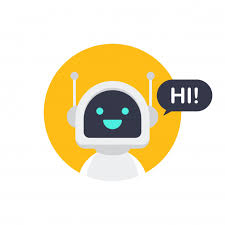
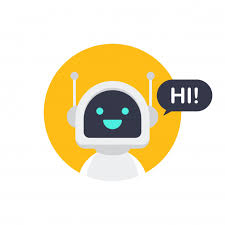

In [ ]:
channel.basic_qos(prefetch_count=1)#numero de mensajes que puede recibir 
channel.basic_consume(queue_name,on_request)
#-----PASO 1.- Inicio: Desencolar mensaje: se llama a la funcion on_request pasando el mensaje descolado-----
print(" [x] Comenzando conversación...")
channel.start_consuming()

In [ ]:
d = "^[a-z0-9]+[\\._]?[a-z0-9]+[@]\\w+[.]\\w{2,3}$"
regex = json.dumps(d)
print("regex",regex)
correo = "oliver@gmail.com"


In [ ]:
regex = eval(regex)
                
if re.search(regex,correo.lower()):                    
    print("Validación correcta")
else: 
    print("falso")